# Movie Recommender System

The objective of this proyect is to create a program that will recommend films to a user. The recommendations will be based on how this user has rated other films. This type of models are used by popular apps such as Netflix or Spotify to recommend films and artists in their platforms.

The program takes in two datasets. The first one is the list of ratings that every user has published. The second one is the list of films. Both datasets have one column in common: 'item_id', which is the ID number for a film. This column will allow us to merge both datasets and to make predictions based on this information.

## Importing the data

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Importing the ratings dataset
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [3]:
# Importing the films dataset
movie_titles = pd.read_csv('Movie_Id_Titles')
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [4]:
# Merging both data frames
df = pd.merge(df, movie_titles, on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100003 entries, 0 to 100002
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    100003 non-null  int64 
 1   item_id    100003 non-null  int64 
 2   rating     100003 non-null  int64 
 3   timestamp  100003 non-null  int64 
 4   title      100003 non-null  object
dtypes: int64(4), object(1)
memory usage: 4.6+ MB


## Exploratory Data Analysis

We will be using the Seaborn library to get information from the dataset. First, we will create a data frame with the average rating and the number of ratings for each film. We will be working with this object to make get information on the films in our list.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [7]:
# Average rating for each film
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
# Number of ratings
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


### Most and least rated films
The graph below suggests that most films in our dataset have almost no ratings. Indeed, after digging deeper, we find that 1059 films in our dataset have less than 50 ratings and 139 have only 1 rating. This could be a problem later in our model, when we'll be making predictions. Films with only one rating are not a good source of information.

On the other hand, very few films seem to have around 600 ratings. Their bars are barely visible in the graph. These are indeed the most popular films, such as Star Wars (1977), Contact (1997) and Fargo (1996). Only 33 films have over 300 ratings.

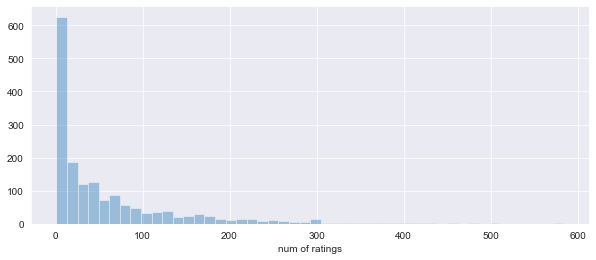

In [8]:
plt.figure(figsize=(10,4))
sns.distplot(ratings['num of ratings'], kde=False)

In [9]:
ratings['num of ratings'].sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: num of ratings, dtype: int64

In [10]:
# number of films with less than 50 ratings
ratings[ratings['num of ratings']<50].count()

rating            1059
num of ratings    1059
dtype: int64

In [11]:
# number of films with only 1 rating
ratings[ratings['num of ratings']==1].count()

rating            134
num of ratings    134
dtype: int64

In [12]:
## number of films with over 300 ratings
ratings[ratings['num of ratings']>300].count()

rating            33
num of ratings    33
dtype: int64

### Distribution of ratings

The first graph in this section shows the distribution of ratings in our dataset. For every given rating, the bar represents the amount of films that received that average rating. As expected from the previous models, the most popular rating is indeed 3.0, followed by 1.0. Whole numbers seem to be the most common rating.

The second graph plots the average rating to number of ratings. In other words, if a film has 600 ratings and an average rating of 4.5, then there will be a small dot in that place. The darker the region, the more dots are in that region, and every dot represents one film in our dataset. As expected, the darkest region is close to the x-axis because most films have almost no ratings. We can also observe that there are some films with average ratings of 5.0, but which have only 1 rating. These probably represent unpopular films, watched by only one person, but who rated them very high. The best films are, of course, those with very high average ratings and also a very high number of ratings. The trend we see in this graph suggests that the more ratings a film has, the better its score (except for films with one or two ratings).

Text(0.5, 1.0, 'Distribution of average ratings in films')

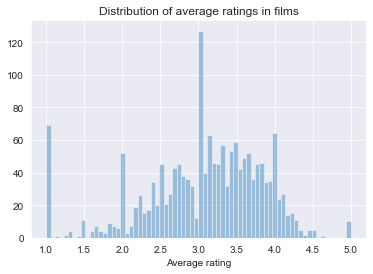

In [13]:
sns.distplot(ratings['rating'], kde=False, bins=70)
plt.xlabel('Average rating')
plt.title('Distribution of average ratings in films')

In [14]:
# most popular average ratings
ratings.groupby('rating').count().sort_values(by='num of ratings', ascending=False).head()

,num of ratings
rating,
3.0,101
1.0,69
2.0,52
4.0,41
2.5,33


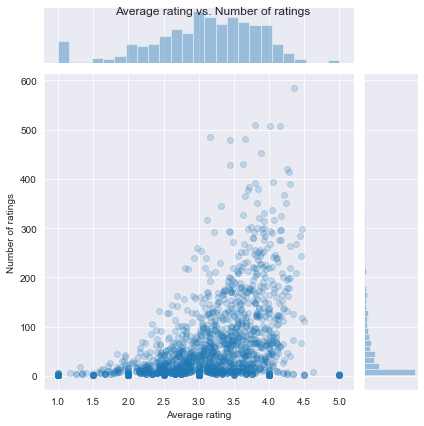

In [15]:
h = sns.jointplot(x='rating', y='num of ratings', data=ratings, alpha=0.2)
h.fig.suptitle('Average rating vs. Number of ratings')
h.ax_joint.set_xlabel('Average rating')
h.ax_joint.set_ylabel('Number of ratings')
plt.tight_layout()

## Creating the recommendation system
Once we have performed an exploratory analysis on the data of our films, we can start crafting the recommender system. We will first create a pivot table where the index will be the users and the columns will be the movies. The value of the cells will be the rating that the user gave to that film. Of course, there will be a lot of NaN because most users have not watched all films.

In [16]:
movie_mat = df.pivot_table(values='rating', index='user_id', columns='title')
movie_mat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculations
To do this process, let's choose two films to work on from the list of the most rated films. Let's say, for example, Scream –a horror movie– and Toy Story –a children movie. We will try to predict similar films to those based on the data on ratings that we have. In the following operations we first take all the ratings for these two movies. We then use this to get how correlated are other films to these two and create a data frame with the results.

Naturally, the most similar movies to Scream and Toy Story will be the ones that are the most correlated. If we sort the list of correlated films by the highest correlation, we should get the most correlated films. But as we saw in our exploratory data analysis, there are some films that have almost no ratings. These are only noise to our system, so we can get rid of it. The first list here is the list of most correlated with the barely-rated films and the second one is the one without.

In [17]:
# most rated movies
ratings['num of ratings'].sort_values(ascending=False).head(10)

title
Star Wars (1977)                 584
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: num of ratings, dtype: int64

In [18]:
# to get a list of all the ratings for these films by every user
scream_user_ratings = movie_mat['Scream (1996)']
toystory_user_ratings = movie_mat['Toy Story (1995)']

In [19]:
# to get a list of the correlation between our two films and every other film
similar_to_scream = movie_mat.corrwith(scream_user_ratings)
similar_to_toystory = movie_mat.corrwith(toystory_user_ratings)

/Users/alexAvila/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/alexAvila/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [20]:
# here is how correlated some films are with Scream (1996):
similar_to_scream.head()

title
'Til There Was You (1997)    0.454859
1-900 (1994)                -0.944911
101 Dalmatians (1996)        0.124059
12 Angry Men (1957)         -0.025659
187 (1997)                   0.382836
dtype: float64

In [21]:
similar_to_toystory.head()

title
'Til There Was You (1997)    0.534522
1-900 (1994)                      NaN
101 Dalmatians (1996)        0.232118
12 Angry Men (1957)          0.334943
187 (1997)                   0.651857
dtype: float64

In [22]:
# data frame of correlation with Scream (1996)
corr_scream = pd.DataFrame(similar_to_scream, columns=['correlation'])
corr_scream.dropna(inplace=True)  # dropping all NaN fields
corr_scream.head()

,correlation
title,
'Til There Was You (1997),0.454859
1-900 (1994),-0.944911
101 Dalmatians (1996),0.124059
12 Angry Men (1957),-0.025659
187 (1997),0.382836


In [23]:
# data frame of correlation with Toy Story (1995)
corr_toystory = pd.DataFrame(similar_to_toystory, columns=['correlation'])
corr_toystory.dropna(inplace=True)
corr_toystory.head()

,correlation
title,
'Til There Was You (1997),0.534522
101 Dalmatians (1996),0.232118
12 Angry Men (1957),0.334943
187 (1997),0.651857
2 Days in the Valley (1996),0.162728


In [24]:
corr_scream.sort_values('correlation', ascending=False)

,correlation
title,
Love and Death on Long Island (1997),1.0
Turbo: A Power Rangers Movie (1997),1.0
Scream (1996),1.0
Caro Diario (Dear Diary) (1994),1.0
Time Tracers (1995),1.0
...,...
New York Cop (1996),-1.0
Open Season (1996),-1.0
"Stranger, The (1994)",-1.0


In [25]:
# joining 'num of ratings' column to our correlation list
corr_scream = corr_scream.join(ratings['num of ratings'])
corr_scream.head()

,correlation,num of ratings
title,,
'Til There Was You (1997),0.454859,9
1-900 (1994),-0.944911,5
101 Dalmatians (1996),0.124059,109
12 Angry Men (1957),-0.025659,125
187 (1997),0.382836,41


In [26]:
# joining 'num of ratings' column to toy story corr table too
corr_toystory = corr_toystory.join(ratings['num of ratings'])
corr_toystory.head()

,correlation,num of ratings
title,,
'Til There Was You (1997),0.534522,9
101 Dalmatians (1996),0.232118,109
12 Angry Men (1957),0.334943,125
187 (1997),0.651857,41
2 Days in the Valley (1996),0.162728,93


## Results
After filtering out the noise, we are able to get the 10 most similar films to these two. Here are the lists:

### Most similar films to Scream (1996)

In [27]:
# filtering out films with less than 100 reviews
corr_scream[corr_scream['num of ratings']>100].sort_values('correlation', ascending=False).head(10)

,correlation,num of ratings
title,,
Scream (1996),1.000000,478
Scream 2 (1997),0.706028,106
Seven (Se7en) (1995),0.435188,236
Starship Troopers (1997),0.419322,211
"Nightmare on Elm Street, A (1984)",0.410796,111
Cape Fear (1991),0.397245,171
Interview with the Vampire (1994),0.386182,137
Natural Born Killers (1994),0.383332,128
Young Guns (1988),0.381230,101


### Most similar films to Toy Story (1995)

In [28]:
corr_toystory[corr_toystory['num of ratings']>100].sort_values('correlation', ascending=False).head(10)

,correlation,num of ratings
title,,
Toy Story (1995),1.000000,452
"Craft, The (1996)",0.549100,104
Down Periscope (1996),0.457995,101
Miracle on 34th Street (1994),0.456291,101
G.I. Jane (1997),0.454756,175
Amistad (1997),0.449915,124
Beauty and the Beast (1991),0.442960,202
"Mask, The (1994)",0.432855,129
Cinderella (1950),0.428372,129


## Conclusion
This is a very simple recommendation system. It doesn't even use machine learning to make the recommendations. However, it does offer a very good insight into the power of the Pandas library for Python. Only by manipulating the data frames and using correlation functions with this library, we were able to get a recommendation system that could be used by some of the finest entertainment web applications in the market. This process, however, would need to be automated with functions to make it a more usable software.